In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import copy 
import seaborn as sb

In [62]:
class TrafficSimulation():
    def __init__(self, length = 100, car_density = 0.3, prob_slow_down = 0.5, max_speed = 5, num_lanes = 2, prob_lane_change = 0.8):  
        self.length = length
        self.car_density = car_density
        self.car_per_lane = int(round(car_density*length))
        self.prob_slow_down = prob_slow_down
        self.max_speed = max_speed
        self.num_lanes = num_lanes
        self.prob_lane_change = prob_lane_change
        self.flow_count = 0
        self.time_step = 0
        self.car_crash = 0
        self.survey = []
        
        self.current_state = -np.ones([self.num_lanes, self.length], dtype=int)
        
        for lane in range(num_lanes):
            random_indices = np.random.choice(
                range(self.length),
                size = self.car_per_lane,
                replace = False)

            self.current_state[lane][random_indices] = np.random.randint(
                0, self.max_speed + 1, size = len(random_indices))
        
    def display(self):
        for lane in range(self.num_lanes):
            print(''.join('.' if x == -1 else str(x) for x in self.current_state[lane]))
        
    def lane_available(self, current_lane, position, next_lane):
        gap = 0
        while self.current_state[current_lane][(position + 1 + gap)%self.length] == -1:
            gap += 1
            
        gap0_forward = -1
        while self.current_state[next_lane][(position + 1 + gap0_forward)%self.length] == -1 and gap0_forward < self.length:
            gap0_forward += 1
            
        gap0_backward = -1    
        while self.current_state[next_lane][(position - 1 - gap0_backward)%self.length] == -1 and gap0_backward < self.length:
            gap0_backward += 1
        
        #The first condition corresponds to the scenario that the car can't accelerate if it stays in the current lane.
        condition1 = gap < self.current_state[current_lane][position] + 1
        #The second condition is to avoid the collision between the current car and the car ahead in the next lane when the current car switch lane.
        condition2 = gap0_forward >= self.current_state[current_lane][position] + 1
        #The third condition is to avoid the collision between the current car and the car behind in the next lane when the current car switch lane.
        condition3 = gap0_backward >= self.max_speed
        #The fourth condition is to randomize the behavior
        condition4 = random.random() < self.prob_lane_change
        
        if condition1 and condition2 and condition3 and condition4:
            return True
        else:
            return False
        
    
    def survey_lane_change(self):
        self.survey = []
        for lane in range(self.num_lanes):
            for position in range(self.length):
                if self.current_state[lane][position] != -1:
                    left_lane = (lane - 1)%self.num_lanes
                    right_lane = (lane + 1)%self.num_lanes
                    
                    if self.lane_available(lane, position, right_lane) == True:
                        self.survey.append([lane, position, right_lane])
                    
                    elif self.lane_available(lane, position, left_lane) == True:
                        self.survey.append([lane, position, left_lane])
                        
                        
    def change_lane(self, current_lane, position, new_lane):
        self.current_state[new_lane][position] = self.current_state[current_lane][position]
        self.current_state[current_lane][position] = -1 
        
        
    def update_speed_same_lane(self, lane, position):
        #identify the next car:
        distance = 1
        while self.current_state[lane][(position + distance) % (self.length)] == -1:
            distance += 1

        #accelerate: 
        if self.current_state[lane][position] < self.max_speed and self.current_state[lane][position] + 1 <= distance -1:
            self.current_state[lane][position] += 1

        #slow down: 
        elif self.current_state[lane][position] >= distance:
            self.current_state[lane][position] = distance - 1

        #random slow: 
        if (self.current_state[lane][position] > 0) and (random.random() < self.prob_slow_down):
            self.current_state[lane][position] -= 1

    def move_car_horizontal(self):
        new_state = -np.ones([self.num_lanes, self.length], dtype=int)
        for lane in range(self.num_lanes):
            for position in range(self.length):
                if self.current_state[lane][position] != -1:
                    new_position = (position + self.current_state[lane][position]) % self.length
                    new_state[lane][new_position] = self.current_state[lane][position]
                    
        self.current_state = new_state
    
    def traffic_count(self):
        self.time_step += 1
        for lane in range(self.num_lanes):
            for position in range(self.length):
                if self.current_state[lane][position] > position:
                    self.flow_count += 1
        
    def update(self, display = False, test = False, count = True):
        if display:
            self.display()
            
        #Make a list of cars that want to change lane: 
        self.survey_lane_change()
                        
        #Change the lanes for the cars that request changing lane. Not changing the speed of the car yet:
        for x in self.survey:
            #x[0] is the current lane, x[1] is the position, x[2] is the new lane
            self.change_lane(x[0], x[1], x[2])
            
        if test:
            if len(self.survey) != 0:
                print("After changing lane: ")
                self.display()
            
        #Update speed within the lane: 
        for lane in range(self.num_lanes):
            for position in range(self.length):
                if self.current_state[lane][position] != -1:
                    self.update_speed_same_lane(lane, position)
        if test:
            print("After updating speed within lane: ")
            self.display()
            
        #Move car with the updated speed:             
        self.move_car_horizontal()
        
        if test:
            print("After moving car: ")
            self.display()
            
        #Count traffic:
        if count: 
            self.traffic_count()

In [44]:
#Test code 1:
random.seed(123)
sim = TrafficSimulation(prob_slow_down = 0)
for _ in range(2):
    print("Time: ", _)
    sim.update(display = True, test = True, count = True)
    print("------")

Time:  0
...20..02..2.....1...1....31.4.21.....451...5....3....4.3.3.....3..32.5.34...0...2.......3.....3....
..3..33.....4..43....5.5.34.3.30........5..5.1.51..5........5.4.....1....2253.4..........3...4..0...
After updating speed within lane: 
...01..02..3.....2...2....01.1.02.....002...4....4....1.1.4.....2..01.1.03...1...3.......4.....4....
..2..04.....2..04....1.1.01.1.01........2..1.1.02..5........1.5.....2....0001.5..........3...2..1...
After moving car: 
...0.1.0..2...3....2...2..0.1.10..2...00..2.....4....4.1.1....4...20.1.10...3.1.....3........4.....4
....20....4...20....4.1.10.1.10.1.........2.1.10..2.....5....1.....5..2..000.1.....5........3..2.1..
------
Time:  1
...0.1.0..2...3....2...2..0.1.10..2...00..2.....4....4.1.1....4...20.1.10...3.1.....3........4.....4
....20....4...20....4.1.10.1.10.1.........2.1.10..2.....5....1.....5..2..000.1.....5........3..2.1..
After changing lane: 
...0.1.0..2...3....2...2..0.1.10..2....0..2.....4....4.1.1....4...20.1.10...3.1.....3......

In [23]:
#Default parameters:
length = 100
prob_slow_down = 0.5
max_speed = 5
prob_lane_change = 1
time_range = 100
density_array = np.linspace(0.05, 0.4, 20)
repeat = 50

In [17]:
#Circular road (one lane) visualization:
sim = TrafficSimulation(car_density = 0.3, num_lanes = 1)
data_first_20_steps = []
data_later_steps = []

for i in range(120):
    if i == 0:
        print("The first 20 steps: ")
    if i == 100: 
        print("After 100 steps: ")
        
    if i <= 20:
        display = True
        data_first_20_steps.append(sim.current_state[0])
    
    elif i >= 100:
        display = True
        data_later_steps.append(sim.current_state[0])
        
    else: 
        display = False
        
    sim.update(display = display)

The first 20 steps: 
.1....125...4...5.5....4.02.0.4......4.10...1.........0.3....5.....1...154....34....0....3.2...2..0.
...2..00...3...30.....40.0.10......5..100.....2.......0.....4.....5.1..00....40...3.0.....1..2...20.
....1.0.1.....30.1....00.0.0.1.......200.1......2......1........4..1..20.1...0.1...10......1....300.
....0.0..1....00...2..0.1.1.1..2.....000..1........3....1.........2..200...2..1.1..0.1.......2..000.
....0..1...2..00.....2.1.10...2..2...00.1...2.........3...2........1.00.1...1.0...2.1.1........200.1
1...0...1...1.0.1....0.0.00.....2...30.1..2....3.........3..2.......100...2..10...0.0...2......000..
..2..1...1...1.1.1...0..10.1......2.00..1....3.....4......1....3....000....1.00....10.....2....000..
...1..1....2.0..1.1...1.0.1..2....0.00....2......4.....4...1.......400.1....10.1...00.......2..000..
....1..1....10...1.1..0.0..1....3.0.0.1.....2........4...2..1......00.1.1...00...2.00.........200.1.
2.....2..2..0.1..0..1.0.0...1....10..1..2.....2........2...2..2....00.

In [18]:
def state_visualize(data_heat_map):
    data_heat_map = np.array(data_heat_map)

    for x in range(len(data_heat_map)):
        for y in range(sim.length):
            if data_heat_map[x][y] > 0:
                data_heat_map[x][y] = 1

    plt.figure(figsize = (20, 4))
    sb.heatmap(data_heat_map)
    plt.xlabel("Road")
    plt.ylabel("Time")
    plt.xticks([])
    plt.yticks([])
    plt.show()

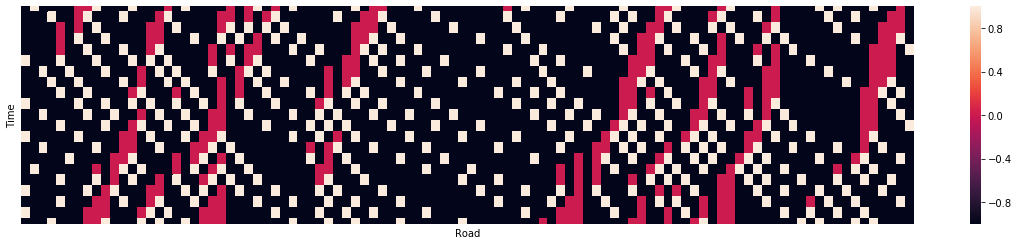

In [19]:
#The first 20 steps: 
state_visualize(data_first_20_steps)

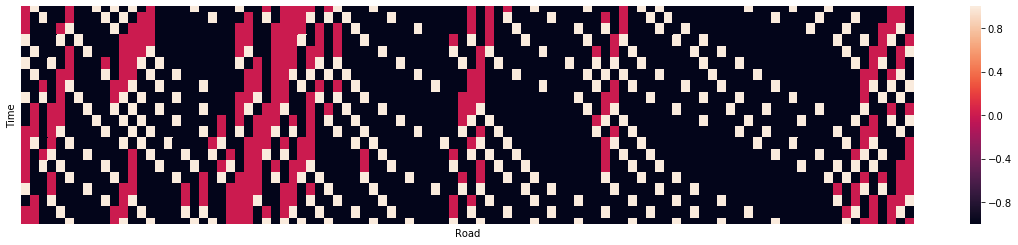

In [20]:
#The later steps (to observe patterns)
state_visualize(data_later_steps)

In [21]:
def time_average_flow(sim, time_range):
    for _ in range(time_range):
        sim.update()
    return sim.flow_count/sim.time_step/sim.num_lanes

In [45]:
#Circular road (one lane)
num_lanes = 1
time_average_flow_1 = []
std_array_1 = []

for car_density in density_array:
    temp_array = []
    
    for _ in range(repeat):
        sim = TrafficSimulation(num_lanes = 1, car_density = car_density)
        temp_array.append(time_average_flow(sim, time_range))
        
    mean = np.mean(temp_array)
    std = np.std(temp_array)
    
    time_average_flow_1.append(mean)
    std_array_1.append(std)

In [25]:
def interval_result(mean_array, std_array):
    upper_bound = np.array(mean_array) + 1.96*np.array(std_array)
    lower_bound = np.array(mean_array) - 1.96*np.array(std_array)
    
    global density_array

    plt.figure()
    plt.plot(density_array, mean_array, color = "Blue")
    plt.plot(density_array, upper_bound, alpha=0.3, color = "Blue")
    plt.plot(density_array, lower_bound, alpha=0.3, color = "Blue")
    plt.xlabel("Density")
    plt.ylabel("Time average flow")
    plt.show()

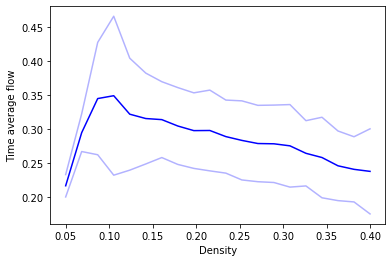

In [46]:
#One lane model's interval: 
interval_result(time_average_flow_1, std_array_1)

In [47]:
def two_lane_visualization(sim):
    data_first_10_steps = []
    data_later_steps = []
    boundary = np.repeat(-2, sim.length)
    for i in range(110):
        if i == 0:
            print("The first 10 steps: ")
        if i == 100: 
            print("After 100 steps: ")

        if i <= 10:
            display = True
            data_first_10_steps.append(sim.current_state[0])
            data_first_10_steps.append(sim.current_state[1])
            data_first_10_steps.append(boundary)

        elif i >= 100:
            display = True
            data_later_steps.append(sim.current_state[0])
            data_later_steps.append(sim.current_state[1])
            data_later_steps.append(boundary)

        else: 
            display = False

        sim.update(display = display)
        if display == True:
            print('--')
        
    print("The first 10 steps: ")
    state_visualize(data_first_10_steps)
    
    print("After 100 steps: ")
    state_visualize(data_later_steps)

The first 10 steps: 
..2..4..5......114..0.1..2......5.2..2.04.....4............3.2............2..0..44005421....0.5.4...
4.......0.........3...23..02..4.2...15.15..2..0..1..1............41....4.43.3.123....3..1.4.....2...
--
4..1..1.....4...0..20...2..2....0..1..10.....5....4.............3...........2.1.0000000..2...1.1....
.....5..0.......1....30..20..20...2.00.0..2.1.0....2..2.......3..0..2..0.0.1.100....4..2.1....4...2.
--
..2..2.1......2.0..0.1....2...3.0....20.1........4.....5...........3.........10.000000.1....3.1..2..
.3.....2.1.......1...00..0.1.0.1..0.00.0..0..1.1....1....3.....1.0....2.1.1.1000.....1..1..2.....3..
--
3..1..1.1......1.1..1.1.....2..10....00..1...........4.....4....1.....3....1.0.1000000...2..0...2...
.....4.0..1........2.0.1.0.0..1.1.0.00.0...1..1..2...1.......4...0.....1..2.000.1.....1...2...3....2
--
..2.1..1.1......1.1..1..2....1.0.1...0.1...2..............5....4..2......3..10.000000.1...1..1.....3
..3..0.0....2.......10..1.10...10..10.10.....2.1...2..1...

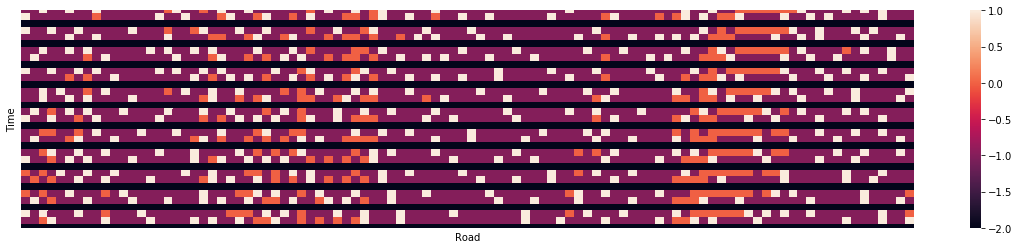

After 100 steps: 


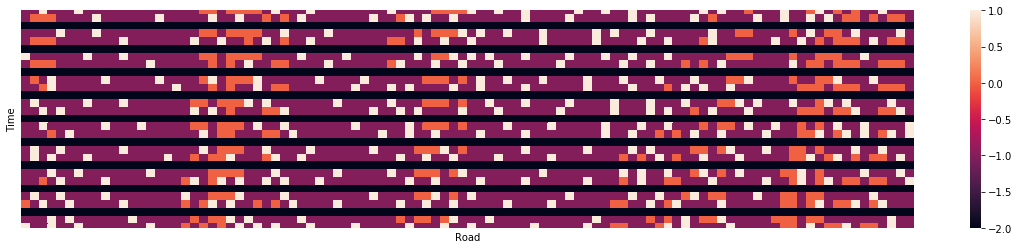

In [48]:
sim = TrafficSimulation(num_lanes = 2)
two_lane_visualization(sim)

In [59]:
#Two-lane model analysis:
time_average_flow_2 = []
std_array_2 = []

for car_density in density_array:
    temp_array = []
    
    for _ in range(repeat):
        sim = TrafficSimulation(car_density = car_density, prob_lane_change = 0.8)
        temp_array.append(time_average_flow(sim, time_range))
        
    mean = np.mean(temp_array)
    std = np.std(temp_array)
    
    time_average_flow_2.append(mean)
    std_array_2.append(std)

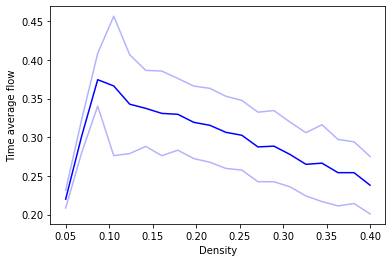

In [60]:
#Two lane model's interval: 
interval_result(time_average_flow_2, std_array_2)

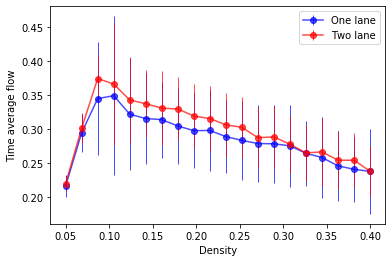

In [61]:
fig, ax = plt.subplots()
ax.errorbar(density_array, time_average_flow_1, yerr = 1.96*np.array(std_array_1), label = "One lane", color ='Blue', elinewidth = 1, fmt='-o', alpha = 0.7)
ax.errorbar(density_array, time_average_flow_2, yerr = 1.96*np.array(std_array_2), label = "Two lane", color ='Red', elinewidth = 1, fmt='-o', alpha = 0.7)
ax.set_xlabel("Density")
ax.set_ylabel("Time average flow")
ax.legend()
plt.show()

In [65]:
#Three-lane model:
time_average_flow_3 = []
std_array_3 = []

for car_density in density_array:
    temp_array = []
    
    for _ in range(repeat):
        sim = TrafficSimulation(num_lanes = 3, car_density = car_density)
        temp_array.append(time_average_flow(sim, time_range))
        
    mean = np.mean(temp_array)
    std = np.std(temp_array)
    
    time_average_flow_3.append(mean)
    std_array_3.append(std)

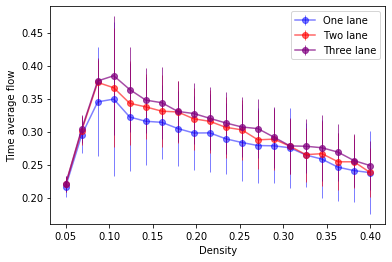

In [66]:
fig, ax = plt.subplots()
ax.errorbar(density_array, time_average_flow_1, yerr = 1.96*np.array(std_array_1), label = "One lane", color ='Blue', elinewidth = 1, fmt='-o', alpha = 0.5)
ax.errorbar(density_array, time_average_flow_2, yerr = 1.96*np.array(std_array_2), label = "Two lane", color ='Red', elinewidth = 1, fmt='-o', alpha = 0.6)
ax.errorbar(density_array, time_average_flow_3, yerr = 1.96*np.array(std_array_2), label = "Three lane", color ='Purple', elinewidth = 1, fmt='-o', alpha = 0.7)
ax.set_xlabel("Density")
ax.set_ylabel("Time average flow")
ax.legend()
plt.show()

In [67]:
#Four-lane model:
time_average_flow_4 = []
std_array_4 = []

for car_density in density_array:
    temp_array = []
    
    for _ in range(repeat):
        sim = TrafficSimulation(num_lanes = 4, car_density = car_density)
        temp_array.append(time_average_flow(sim, time_range))
        
    mean = np.mean(temp_array)
    std = np.std(temp_array)
    
    time_average_flow_4.append(mean)
    std_array_4.append(std)

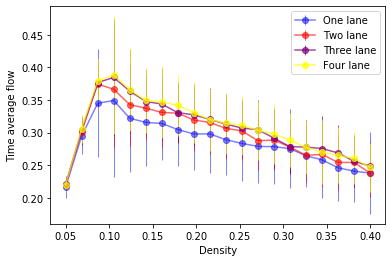

In [69]:
fig, ax = plt.subplots()
ax.errorbar(density_array, time_average_flow_1, yerr = 1.96*np.array(std_array_1), label = "One lane", color ='Blue', elinewidth = 1, fmt='-o', alpha = 0.5)
ax.errorbar(density_array, time_average_flow_2, yerr = 1.96*np.array(std_array_2), label = "Two lane", color ='Red', elinewidth = 1, fmt='-o', alpha = 0.6)
ax.errorbar(density_array, time_average_flow_3, yerr = 1.96*np.array(std_array_2), label = "Three lane", color ='Purple', elinewidth = 1, fmt='-o', alpha = 0.7)
ax.errorbar(density_array, time_average_flow_4, yerr = 1.96*np.array(std_array_2), label = "Four lane", color ='Yellow', elinewidth = 1, fmt='-o', alpha = 0.7)
ax.set_xlabel("Density")
ax.set_ylabel("Time average flow")
ax.legend()
plt.show()

In [96]:
####STRETCH GOALS
class TrafficSimulation2():
    def __init__(self, length = 100, car_density = 0.2, prob_slow_down = 0.5, 
        max_speed = 5, num_lanes = 2, prob_lane_change = 0.8, prob_obstacle = 0, mergeratio = 0,
        red_time_range = 0, green_time_range = 0):
        
        self.length = length
        self.car_density = car_density
        self.car_per_lane = int(round(car_density*length))
        self.prob_slow_down = prob_slow_down
        self.max_speed = max_speed
        self.num_lanes = num_lanes
        self.prob_lane_change = prob_lane_change
        self.prob_destruction = prob_obstacle
        self.isolation_distance = 1
        self.flow_count = 0
        self.time_step = 0
        self.track_num_cars = 0
        self.survey = []
        self.car_crash = False
        
        self.default_speed_limit = self.max_speed*np.ones([self.num_lanes, self.length], dtype=int)
        
        self.current_state = -np.ones([self.num_lanes, self.length], dtype=int)
        
        self.traffic_light_position = round(1/2*length)
        self.red_time_range = red_time_range
        self.green_time_range = green_time_range
        self.light_color = "green"
        
        self.speed_limit_array = self.max_speed * np.ones([self.num_lanes, self.length], dtype=int)
        
        #mergesize = round(1/2*length)
        mergesize = round(mergeratio*self.length)
        
        if mergesize > 0: 
            ignored_indices = np.arange(self.length - mergesize, self.length)
            self.current_state[1][ignored_indices] = np.repeat(-2, mergesize)
        
        for lane in range(num_lanes):
            if lane == 0:
                random_indices = np.random.choice(
                    range(self.length),
                    size = self.car_per_lane,
                    replace = False)
            else:
                random_indices = np.random.choice(
                    range(self.length - mergesize),
                    size = self.car_per_lane,
                    replace = False)
                
            self.current_state[lane][random_indices] = np.random.randint(
                0, self.max_speed + 1, size = len(random_indices))
            
        #i = 15
        #while self.current_state[0][i] != -1:
            #i += 1
        #self.current_state[0][i] = -2
        
    def display(self):
        for lane in range(self.num_lanes):
            print(''.join('.' if x == -1 else 'X' if x == -2 else str(x) for x in self.current_state[lane]))
    
    def lane_available(self, current_lane, position, next_lane):
        gap = 0
        while self.current_state[current_lane][(position + 1 + gap)%self.length] == -1:
            gap += 1
            
        gap0_forward = -1
        while self.current_state[next_lane][(position + 1 + gap0_forward)%self.length] == -1 and gap0_forward < self.length:
            gap0_forward += 1
            
        gap0_backward = -1    
        while self.current_state[next_lane][(position - 1 - gap0_backward)%self.length] == -1 and gap0_backward < self.length:
            if self.current_state[next_lane][(position - 1 - gap0_backward)%self.length] == -2:
                gap0_backward = 1000
                break
            else:
                gap0_backward += 1
        
        #The first condition corresponds to the scenario that the car can't accelerate if it stays in the current lane.
        condition1 = gap < self.current_state[current_lane][position] + 1
        #The second condition is to avoid the collision between the current car and the car ahead in the next lane when the current car switch lane.
        condition2 = gap0_forward >= self.current_state[current_lane][position] + 1
        #The third condition is to avoid the collision between the current car and the car behind in the next lane when the current car switch lane.
        condition3 = gap0_backward >= self.max_speed
        #The fourth condition is to randomize the behavior
        condition4 = random.random() < self.prob_lane_change
        
        #Condition 5 is added for the stretched goal: the car at the light traffic position are not allowed to change lane if it's red light
        #This means that if the speed limit is 0, the all the motions are prohibited
        if self.speed_limit_array[current_lane][position] == 0:
            condition5 = False
        else:
            condition5 = True
        
        if condition1 and condition2 and condition3 and condition4 and condition5:
            return True
        else:
            return False
        
    
    def survey_lane_change(self):
        self.survey = []
        for lane in range(self.num_lanes):
            for position in range(self.length):
                if self.current_state[lane][position] >= 0:
                    left_lane = (lane - 1)%self.num_lanes
                    right_lane = (lane + 1)%self.num_lanes
                    
                    if self.lane_available(lane, position, right_lane) == True or self.excused_lane_change(lane, position, right_lane) == True:
                        self.survey.append([lane, position, right_lane])
                    
                    elif self.lane_available(lane, position, left_lane) == True or self.excused_lane_change(lane, position, left_lane) == True:
                        self.survey.append([lane, position, left_lane])
                        
                        
    def change_lane(self, current_lane, position, new_lane):
        self.current_state[new_lane][position] = self.current_state[current_lane][position]
        self.current_state[current_lane][position] = -1 
        
    def excused_lane_change(self, lane, position, next_lane):
        condition1 = False
        for i in range(1, self.isolation_distance + 1):
            if self.current_state[lane][(position + i)%self.length] >= 0:
                break
            if self.current_state[lane][(position + i)%self.length] == -2:
                condition1 = True
                break
                
        gap0_forward = -1
        while self.current_state[next_lane][(position + 1 + gap0_forward)%self.length] == -1 and gap0_forward < self.length:
            gap0_forward += 1
            
        gap0_backward = -1    
        while self.current_state[next_lane][(position - 1 - gap0_backward)%self.length] == -1 and gap0_backward < self.length:
            gap0_backward += 1
        
        #When the car switch lane to avoid the obstacle, the limit for the gap0_forward is different from the previous limit
        #as the purpose is different. 
        #The second condition is to avoid the collision between the current car and the car ahead in the next lane when the current car switch lane.
        condition2 = gap0_forward >= self.current_state[lane][position]
        
        #The third condition is to avoid the collision between the current car and the car behind in the next lane when the current car switch lane.
        condition3 = gap0_backward >= 0
            
        if condition1 and condition2 and condition3: 
            return True
        else:
            return False
        
    def update_speed_same_lane(self, lane, position):
        obstacle_ahead = False 
        #obstacle identify:
        for i in range(1, self.isolation_distance + 1):
            if self.current_state[lane][(position + i)%self.length] >= 0:
                break
            if self.current_state[lane][(position + i)%self.length] == -2:
                obstacle_ahead = True
                
        if obstacle_ahead:
            self.current_state[lane][position] = 0
            
        else:
            #identify the next car:
            distance = 1
            while self.current_state[lane][(position + distance) % (self.length)] == -1:
                distance += 1

            #accelerate: 
            if self.current_state[lane][position] < self.max_speed and self.current_state[lane][position] + 1 <= distance -1:
                self.current_state[lane][position] += 1

            #slow down: 
            if self.current_state[lane][position] >= distance:
                self.current_state[lane][position] = distance - 1

            #random slow: 
            if (self.current_state[lane][position] > 0) and (random.random() < self.prob_slow_down):
                self.current_state[lane][position] -= 1
                
            #follow the speed limit for each cell, especially the cells of traffic lights:
            if self.current_state[lane][position] > self.speed_limit_array[lane][position]:
                self.current_state[lane][position] = self.speed_limit_array[lane][position]

        #Random destruction: 
        if random.random() < self.prob_destruction:
            self.current_state[lane][position] = -2
        
    def move_car_horizontal(self):
        new_state = -np.ones([self.num_lanes, self.length], dtype=int)
        for lane in range(self.num_lanes):
            for position in range(self.length):
                if self.current_state[lane][position] >= 0:
                    new_position = (position + self.current_state[lane][position]) % self.length
                    new_state[lane][new_position] = self.current_state[lane][position]
                
                elif self.current_state[lane][position] == -2:
                    new_state[lane][position] = -2
                    
        self.current_state = new_state
    
    def traffic_count(self):
        self.time_step += 1
        for lane in range(self.num_lanes):
            for position in range(self.length):
                if self.current_state[lane][position] > position:
                    self.flow_count += 1
                    
    def check_num_cars(self):
        self.track_num_cars = 0
        for lane in range(self.num_lanes):
            for position in range(self.length):
                if self.current_state[lane][position] >= 0:
                    self.track_num_cars += 1
        
    def light_traffic_work(self):
        if self.green_time_range + self.red_time_range != 0:
            consider = self.time_step % (self.green_time_range + self.red_time_range)
            if consider < self.green_time_range:
                self.light_color = "green"
            else: 
                self.light_color = "red"

            #update speed limit according to the light color:
            for lane in range(self.num_lanes):
                if self.light_color == "green":
                    self.speed_limit_array[lane][self.traffic_light_position] = self.max_speed

                elif self.light_color == "red":
                    self.speed_limit_array[lane][self.traffic_light_position] = 0
            
        
    def update(self, display = False, test = False, count = True, safety_check = False):
        if display:
            self.display()
            
        #Traffic lights work: 
        self.light_traffic_work()
        
        #Make a list of cars that want to change lane: 
        self.survey_lane_change()
                        
        #Change the lanes for the cars that request changing lane. Not changing the speed of the car yet:
        for x in self.survey:
            #x[0] is the current lane, x[1] is the position, x[2] is the new lane
            self.change_lane(x[0], x[1], x[2])  
        if test:
            if len(self.survey) != 0:
                print("After changing lane: ")
                self.display()
            
        #Update speed within the lane: 
        for lane in range(self.num_lanes):
            for position in range(self.length):
                if self.current_state[lane][position] >= 0:
                    self.update_speed_same_lane(lane, position)
        if test:
            print("After updating speed within lane: ")
            self.display()
            
        #Move car with the updated speed:             
        self.move_car_horizontal()
        
        if test:
            print("After moving car: ")
            self.display()
        
        if safety_check:
            self.check_num_cars()
            print("Number of cars: ", self.track_num_cars)
            
        #Count traffic:
        if count: 
            self.traffic_count()

In [ ]:
#Test code: 
random.seed(123)
sim = TrafficSimulation2()
for i in range(40):
    print("Light color: ", sim.light_color)
    sim.update(display = True, safety_check = True)
    print("--")

In [92]:
sim = TrafficSimulation2()

#visualize the speed limit change: 
lower_speed_indices = np.arange(round(sim.length/2), sim.length)

for lane in range(sim.num_lanes):
    sim.speed_limit_array[lane][lower_speed_indices] = np.repeat(round(1/2*sim.max_speed), len(lower_speed_indices))
for lane in range(sim.num_lanes):
    for position in range(sim.length):
        if sim.current_state[lane][position] > sim.speed_limit_array[lane][position]:
            sim.current_state[lane][position] = sim.speed_limit_array[lane][position]
            
for _ in range(10):
    sim.update(display = True)
    print("--")

..3.............1...1.5............4...0..31.....5..2....1...2.1.....2......2...2...0..2........20..
.3..3............5....2.2..........1....3...35.............2.2..2.........2.2......2....10.2...2...2
--
.....3...........1...1.....5.........2..1.0..2.....2..2...1...1.1......2......2...2.0....2......0.1.
...2...3............3..1...3.........2....2.0....4..........1..2..2........1..2......2..0.1..2...2.0
--
.........4........1...1.........5......20.0....2.....2..2...2..1..2......2......2.0..1.....2.....1.1
1.....3....4.........1..1......4........3..1.1........5.......2.1...2.......1...2......2.1.1...2..1.
--
.2...........4......2..1............4..0.1.1......3...1...2..1..1...2......2....0.0...1......2....1.
..2.......4.....5.....1...2.........5.....2.1.1.........2.....0..1....2......1....2....0.0...2..1..1
--
2...3............4...1..1.............2.1.1..2......2..1...1..1..1....2......2...10....1.......2....
.2..2.........4.....4..1....2............50.0..1..........2....1...2....2.....1

In [100]:
#Effect of different speed limit:
mean0 = []
std0 = []
mean1 = []
std1 = []

for car_density in density_array:
    temp_array0 = []
    temp_array1 = []
    for _ in range(repeat):
        sim0 = TrafficSimulation2(car_density = car_density)
        sim1 = copy.deepcopy(sim0)
        #Choose an area that have lower speed limit (1/2*max speed):
        #The later half of the road will have the speed limit of 1/2 max speed:
        lower_speed_indices = np.arange(round(sim1.length/2), sim1.length)
        for lane in range(sim1.num_lanes):
            sim1.speed_limit_array[lane][lower_speed_indices] = np.repeat(round(1/2*sim1.max_speed), len(lower_speed_indices))
        #Revise the original speed to fit the new_speed limit:
        for lane in range(sim.num_lanes):
            for position in range(sim.length):
                if sim.current_state[lane][position] > sim.speed_limit_array[lane][position]:
                    sim.current_state[lane][position] = sim.speed_limit_array[lane][position]
                    
        temp_array0.append(time_average_flow(sim0, time_range))
        temp_array1.append(time_average_flow(sim1, time_range))
        
    mean0.append(np.mean(temp_array0))
    std0.append(np.std(temp_array0))
    mean1.append(np.mean(temp_array1))
    std1.append(np.std(temp_array1))

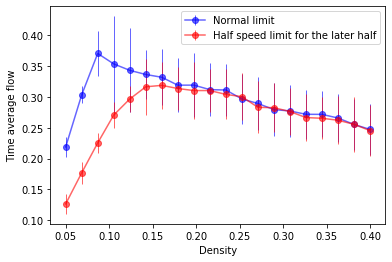

In [101]:
#Visualize result
fig, ax = plt.subplots()
ax.errorbar(density_array, mean0, yerr = 1.96*np.array(std0), label = "Normal limit", color ='Blue', elinewidth = 1, fmt='-o', alpha = 0.6)
ax.errorbar(density_array, mean1, yerr = 1.96*np.array(std1), label = "Half speed limit for the later half", color ='Red', elinewidth = 1, fmt='-o', alpha = 0.6)
ax.set_xlabel("Density")
ax.set_ylabel("Time average flow")
ax.legend()
plt.show()

In [102]:
#Visualize the traffic light: 
sim = TrafficSimulation2(red_time_range = 10, green_time_range = 10)

for _ in range(20):
    print("light color: ", sim.light_color)
    sim.update(display = True)
    print("--")  

light color:  green
.3......2.....0.....3.4.04....4.....41.......2203...........5...5.2.....................5....14.....
.0....0.20......41...........3...............1..5...4........3...4...2...1....52.........5..44..4...
--
light color:  green
.....4.....3..0......1..2....4.....5...2.....000....4..........3.1..2.............4........3.0....4.
40.....10.1.....0..2....0.......3........5....1...2.....4.......3..2....3.1.......3........20.1.....
--
light color:  green
...5......5..2.1......1...2.......5..2....3..000.........5.....0...2...3..............4.....1.1.....
00.....00...2...0....2..0..........3........3..1....2........5....2...3..1..2.........4....00...2...
--
light color:  green
.1.....4...1.0...2......2...2.......2..2...1.000..............50......3....4..............4..1..2...
.0.....0.1....2.0.....1..1............3.......2..2.....3.........4...3.1...2..2..........3.0.1.....3
--
light color:  green
...2.....2..1.1.....3.....2...2......1....3.100.1.............0.1........3.....4

In [107]:
repeat = 10
#Effect of traffic light:
mean0 = []
std0 = []
mean1 = []
std1 = []

for car_density in density_array:
    temp_array0 = []
    temp_array1 = []
    for _ in range(repeat):
        #by default, the traffic light is always green. 
        sim0 = TrafficSimulation2(car_density = car_density)
        
        sim1 = copy.deepcopy(sim0)
        #set time range for the red light and the green light
        sim1.red_time_range = 10
        sim1.green_time_range = 10
        
        temp_array0.append(time_average_flow(sim0, time_range))
        temp_array1.append(time_average_flow(sim1, time_range))
        
    mean0.append(np.mean(temp_array0))
    std0.append(np.std(temp_array0))
    mean1.append(np.mean(temp_array1))
    std1.append(np.std(temp_array1))

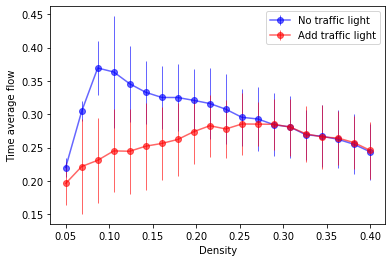

In [104]:
#Visualize result
fig, ax = plt.subplots()
ax.errorbar(density_array, mean0, yerr = 1.96*np.array(std0), label = "No traffic light", color ='Blue', elinewidth = 1, fmt='-o', alpha = 0.6)
ax.errorbar(density_array, mean1, yerr = 1.96*np.array(std1), label = "Add traffic light", color ='Red', elinewidth = 1, fmt='-o', alpha = 0.6)
ax.set_xlabel("Density")
ax.set_ylabel("Time average flow")
ax.legend()
plt.show()

In [124]:
#Visualize random obstacle:
sim = TrafficSimulation2()
random_position = 0
while sim.current_state[0][random_position] >= 0:
    random_position = np.random.randint(0, sim.length)
sim.current_state[0][random_position] = -2

for _ in range(10):
    sim.update(display = True)
    print("--")

X32.....1..2.....4...........3......2..2........3....2...........455...45.......4.....0..2..1...0...
4...3.300.........2.4...............0......1...2...........1........5.....1..22..21.....23.5........
--
X0..2.....2...3......4..........3.....2..2..........4...3........00...30....4........5.1..1..1...1..
..2..100.1.........1....4............1.......2...2...........2..........4...20.1.0..2...0.1....4....
--
X.1....3.....3....4.......5........3...1...2...........3....4....00...0.1.......4....0..1..1..1....2
5..1.00.1.1.........1.......4.........1........2....3...........3..........30.10.0....2.0...2.......
--
X...2.....3.....3.....4.......4......2..1....2.............4....400...0..1.........3.0....2.1..1...0
..20.00..1.1..........2..........5.....1..........3....3...........3.......00.00..1...0..1....2.....
--
X......3.....3......4......5.......5...2.1......3.............3.0.0...0....2.......0.0.....1..2.1...
..00.0.1.0...2...........3...........4..1.............4...3......0.....4...0.10

In [125]:
#Effect of random obstacle
mean0 = []
std0 = []
mean1 = []
std1 = []

for car_density in density_array:
    temp_array0 = []
    temp_array1 = []
    for _ in range(repeat):
        #by default, the traffic light is always green. 
        sim0 = TrafficSimulation2(car_density = car_density)
        
        sim1 = copy.deepcopy(sim0)
        #position of obstacle:
        random_position = round(1/2*sim1.length)
        while sim1.current_state[0][random_position] >= 0:
            random_position = np.random.randint(0, sim1.length)
        sim1.current_state[0][random_position] = -2
        
        temp_array0.append(time_average_flow(sim0, time_range))
        temp_array1.append(time_average_flow(sim1, time_range))
        
    mean0.append(np.mean(temp_array0))
    std0.append(np.std(temp_array0))
    mean1.append(np.mean(temp_array1))
    std1.append(np.std(temp_array1))

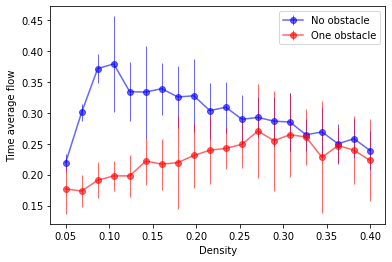

In [126]:
#Visualize result
fig, ax = plt.subplots()
ax.errorbar(density_array, mean0, yerr = 1.96*np.array(std0), label = "No obstacle", color ='Blue', elinewidth = 1, fmt='-o', alpha = 0.6)
ax.errorbar(density_array, mean1, yerr = 1.96*np.array(std1), label = "One obstacle", color ='Red', elinewidth = 1, fmt='-o', alpha = 0.6)
ax.set_xlabel("Density")
ax.set_ylabel("Time average flow")
ax.legend()
plt.show()

In [110]:
#Visualize merge lane:
sim = TrafficSimulation2(mergeratio = 0.2)

for _ in range(10):
    sim.update(display = True)
    print("--")

.............53......4...23.....1...2....10.....3...................45........33......30.0...32...5.
.....2.4......02...1.5..3..1.22.5..5.............5.....5.043...3.............1.4XXXXXXXXXXXXXXXXXXXX
--
..4....2.....0...3......30...3....2...2....1.......3...0.00...3.....0....4....0....4..0.10...0...3..
...........4..0...30..1..1..100...2.....5.1..........4............3..........0.0XXXXXXXXXXXXXXXXXXXX
--
.4...3...2....1......4..00......3...2...2....2........3.10.1.....3..0.......3.00....1..10.1...1.....
............1..1..00....2.1.000.....2...0..1..............5..........3........1.XXXXXXXXXXXXXXXXXXXX
--
.....4......3..1......1.0.1.......2...2...2....2.......10.1..2.....2.1......0.00.....1.0.1..2...2...
.........4...1..1.0.1...0.0.000.......2..1..1.................4.........3.....0.XXXXXXXXXXXXXXXXXXXX
--
.........4....2.1.....0..1..2.......2...2....3....3......1..2...3...1..2.....100.....0.0...2..2...2.
...........2...2.1.1..2.0.0.000.........2..2.1...........2.........5.......3...

In [122]:
#Effect of merge_lane:
mean0 = [] 
std0 = []
mean1 = []
std1 = []

for car_density in density_array:
    temp_array0 = []
    temp_array1 = []
    
    for _ in range(repeat):
        #by default, the traffic light is always green. 
        sim1 = TrafficSimulation2(car_density = car_density, mergeratio = 0.2)
        temp_array1.append(time_average_flow(sim1, time_range))
        
    for _ in range(repeat):
        sim0 = TrafficSimulation2(car_density = car_density)
        temp_array0.append(time_average_flow(sim0, time_range))
        
    mean0.append(np.mean(temp_array0))
    std0.append(np.std(temp_array0))    
    mean1.append(np.mean(temp_array1))
    std1.append(np.std(temp_array1))

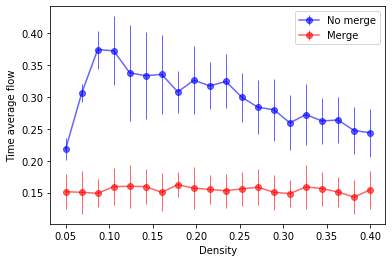

In [123]:
#Visualize result
fig, ax = plt.subplots()
ax.errorbar(density_array, mean0, yerr = 1.96*np.array(std0), label = "No merge", color ='Blue', elinewidth = 1, fmt='-o', alpha = 0.6)
ax.errorbar(density_array, mean1, yerr = 1.96*np.array(std1), label = "Merge", color ='Red', elinewidth = 1, fmt='-o', alpha = 0.6)
ax.set_xlabel("Density")
ax.set_ylabel("Time average flow")
ax.legend()
plt.show()